### Stock Price Prediction Using LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv('AXISBANK.csv')

In [3]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,31-03-2016,AXISBANK,EQ,444.25,443.7,449.00,438.20,445.5,444.15,443.86,12671936,5.624600e+14,249206,8049354,0.6352
1,01-04-2016,AXISBANK,EQ,444.15,440.9,452.00,440.05,449.6,449.90,447.47,8827751,3.950180e+14,113540,4637271,0.5253
2,04-04-2016,AXISBANK,EQ,449.90,451.5,451.55,442.10,445.2,444.75,445.86,5347581,2.384300e+14,71535,2743497,0.5130
3,05-04-2016,AXISBANK,EQ,444.75,443.4,449.50,431.00,431.3,432.60,439.70,12100258,5.320490e+14,150725,5251685,0.4340
4,06-04-2016,AXISBANK,EQ,432.60,433.3,436.30,423.10,427.0,424.65,427.39,7457831,3.187400e+14,80896,3650425,0.4895


In [4]:
# extracting data from column "Close" into new dataframe
df1=df.reset_index()['Close']

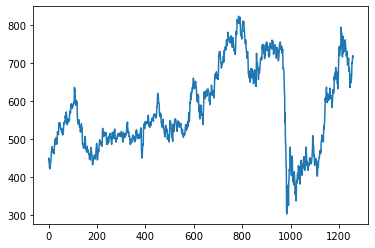

In [5]:
plt.plot(df1)

In [6]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler to scale the values in between 0 and 1
from sklearn.preprocessing import MinMaxScaler
# To scale the values in between 0 and 1
sc = MinMaxScaler(feature_range=(0,1)) 
df1=sc.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
print(df1)

[[0.27133648]
 [0.28240162]
 [0.2724911 ]
 ...
 [0.77937073]
 [0.80101992]
 [0.79236024]]


In [8]:
#splitting dataset into train and test split
train_size=int(len(df1)*0.65)
test_size=len(df1)-train_size
train_data,test_data=df1[0:train_size,:],df1[train_size:len(df1),:1]

In [9]:
def to_update_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
time_step = 100
X_train, y_train = to_update_dataset(train_data, time_step)
X_test, ytest = to_update_dataset(test_data, time_step)

In [11]:
# reshape input into such a manner that it can be taken by LSTM [samples, time steps, features]
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [12]:
# Creating the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [13]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=5,batch_size=64,verbose=1)

Epoch 1/5
12/12 [==============================] - 14s 586ms/step - loss: 0.1103 - val_loss: 0.0186
Epoch 2/5
12/12 [==============================] - 4s 302ms/step - loss: 0.0140 - val_loss: 0.0166
Epoch 3/5
12/12 [==============================] - 4s 313ms/step - loss: 0.0075 - val_loss: 0.0160
Epoch 4/5
12/12 [==============================] - 4s 341ms/step - loss: 0.0051 - val_loss: 0.0143
Epoch 5/5
12/12 [==============================] - 4s 320ms/step - loss: 0.0032 - val_loss: 0.0123


In [16]:
import tensorflow as tf

In [17]:
# Prediction
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

In [18]:
# Transform output back to original form so it can be compared with actual values
train_prediction=sc.inverse_transform(train_prediction)
test_prediction=sc.inverse_transform(test_prediction)

In [19]:
x_input=test_data[341:].reshape(1,-1)

In [20]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [21]:
# Calculating prediction for next 30 days
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        y_predicted = model.predict(x_input, verbose=0)
        temp_input.extend(y_predicted[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(y_predicted.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        y_predicted = model.predict(x_input, verbose=0)
#         print(yhat[0])
        temp_input.extend(y_predicted[0].tolist())
#         print(len(temp_input))
        lst_output.extend(y_predicted.tolist())
        i=i+1
    
print('Output of all days from day 1 to day 30')
print(lst_output)

Output of all days from day 1 to day 30
[[0.7111889719963074], [0.7131728529930115], [0.7151753902435303], [0.7168945670127869], [0.7181879281997681], [0.7190201878547668], [0.71942138671875], [0.7194536328315735], [0.7191910743713379], [0.7187061905860901], [0.7180630564689636], [0.7173134088516235], [0.7164971828460693], [0.715644121170044], [0.7147741317749023], [0.7139002680778503], [0.7130308151245117], [0.7121697664260864], [0.7113192677497864], [0.710479736328125], [0.7096506953239441], [0.7088316082954407], [0.7080216407775879], [0.707219660282135], [0.7064253091812134], [0.7056376934051514], [0.7048565745353699], [0.7040818333625793], [0.703312873840332], [0.7025495767593384]]


In [22]:
d_new=np.arange(1,101)
d_pred=np.arange(101,131)

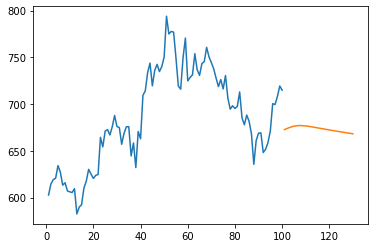

In [23]:
# plotting our predicted output from day 1 t day 30 using orange line
plt.plot(d_new,sc.inverse_transform(df1[1158:]))
plt.plot(d_pred,sc.inverse_transform(lst_output))

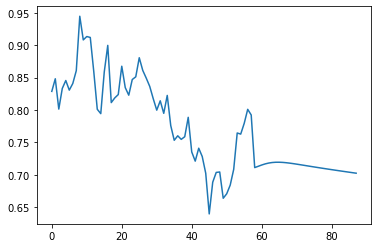

In [24]:
# plotting actual output from the data that we have 
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])